# Species Distribution Model

Species distribution modelling commonly requires two categories of data: (1) species data and (2) environmental data. Species data can be nominal (presence/absence records), ordinal (ranked abundances), or ratio (abundance and richness). Environmental data refers to both biotic and abiotic conditions

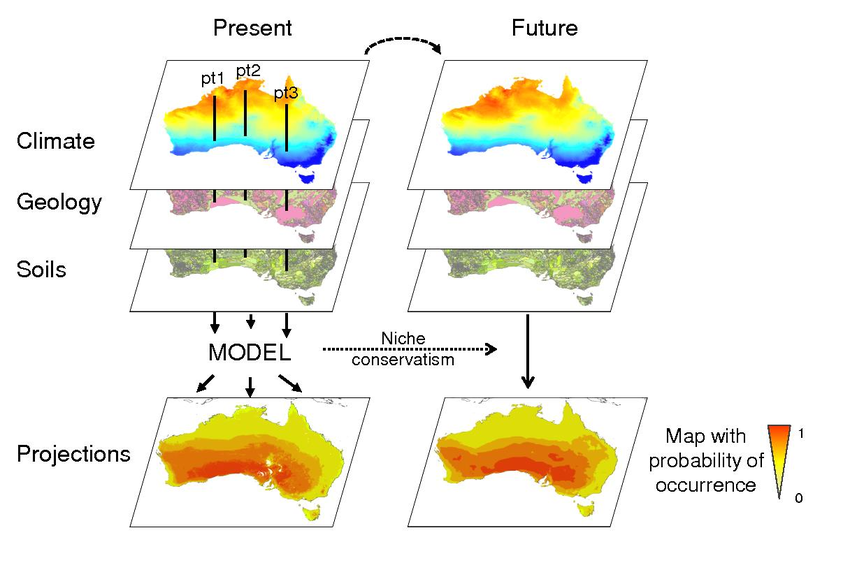

# Import libraries

In [1]:
pip install pyimpute

  Preparing metadata (setup.py) ... done
  Created wheel for pyimpute: filename=pyimpute-0.3-py3-none-any.whl size=6044 sha256=65b556eb94e51e6afe7edbc830fdbf32dface871e1c075c0214b6a323a9c0be7
  Stored in directory: /root/.cache/pip/wheels/cd/7a/bc/e4e769aa6d7ecdb00cc5579f9d3ace47ac430c99f4665387c5
Successfully built pyimpute
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install basemap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.0/866.0 kB 9.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 28.4 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install basemap-data-hires

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 MB 10.7 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import shapely.geometry
from shapely.geometry import Point
from mpl_toolkits.basemap import Basemap
import glob
import rasterio
import os
import shutil
import pyimpute
from pathlib import Path

import warnings
warnings.simplefilter(action='ignore')

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# Read files

**CNAT = Carta Natura (Sardinian Island Polygons)**

**data = Occurrence of species in coastal areas (Points)**

In [5]:
# Polygons of species habitats
CNAT = gpd.read_file("/kaggle/input/cnat-2013/CNAT_SAR2013_v1.shp")
# convert to EPSG:4326, which corresponds to coordinates in latitude and longitude.
CNAT = CNAT.to_crs("EPSG:4326")


# Species presence
data = pd.read_csv('/kaggle/input/filtered-species/Plants_coasts_filtered.csv')

# Buffer
bfr_dist = 100 #100m buffer around each species occurrence point

**Target Species: Crithmum maritimum**

In [6]:
presence = data[data['species'] == "Crithmum maritimum"]

In [7]:
# Rename column occurrenceStatus to CLASS, and set 1 for presence
presence.rename(columns = {'occurrenceStatus':'CLASS'}, inplace = True)
presence['CLASS'] = 1

In [8]:
# Recreating the geometry column with longitudinal and latitudinal coordinates 
presence['geometry'] = list(zip(presence["decimalLongitude"], presence["decimalLatitude"]))
# Code to get coordinate points
presence['geometry'] = presence["geometry"].apply(Point)

In [9]:
# Create the geodataframe
presence = gpd.GeoDataFrame(presence,
            crs = {'init': 'epsg:4326'},
           geometry = presence['geometry'])

presence = presence.to_crs("EPSG:4326")
presence.reset_index(drop=True, inplace = True)
presence.head()

,species,CLASS,CODICE,decimalLatitude,decimalLongitude,geometry
0,Crithmum maritimum,1,16.10,40.253916,8.476496,POINT (8.47650 40.25392)
1,Crithmum maritimum,1,16.10,40.224045,9.626632,POINT (9.62663 40.22404)
2,Crithmum maritimum,1,18.22,40.642377,8.188163,POINT (8.18816 40.64238)
3,Crithmum maritimum,1,18.22,40.575891,8.160995,POINT (8.16099 40.57589)
4,Crithmum maritimum,1,18.22,40.579098,8.156221,POINT (8.15622 40.57910)


In [10]:
# Arbitrary coordinate generation functions
def random_points_in_gdf(gdf, size, overestimate=2):
    polygon = gdf['geometry'].unary_union # Union
    min_x, min_y, max_x, max_y = polygon.bounds # polygonal habitats
    ratio = polygon.area / polygon.envelope.area # Area ratio = Area of polygon / Area of selection rectangle
    
    # Generate random coordinates: Number of points (size) / Surface (ratio) * Overestimate 
    samples = np.random.uniform((min_x, min_y), (max_x, max_y), (int(size / ratio * overestimate), 2))
    multipoint = shapely.geometry.MultiPoint(samples)
    multipoint = multipoint.intersection(polygon)
    samples = np.array(multipoint)
    points = samples[np.random.choice(len(samples), size)]
    df = pd.DataFrame(points, columns=['decimalLongitude', 'decimalLatitude'])
    return gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.decimalLongitude, df.decimalLatitude))

# Pseudo-absence creation functions
def create_absence_points(presence, total_area, radius, count):
    presence_bfr = presence.to_crs(5179) # Projected coordinate system
    presence_bfr['geometry'] = presence_bfr.geometry.buffer(radius)
    presence_bfr = presence_bfr.to_crs(4326) # Geographic coordinate system
    
    # Difference = total area - presence buffer
    res_difference = total_area.overlay(presence_bfr, how='difference')
    
    # Random point generation functions
    absence = random_points_in_gdf(res_difference, count)
    absence['CLASS'] = 0
    return absence

**What are pseudo-absences?**

Pseudo-absences (sometimes also referred as background data) are NOT to be considered as absences, and rather represent the available environment in the studied area. They will be used to compare observed used environment (represented by the presences) against what is available

In [11]:
# Create pseudo-absence
absence = create_absence_points(presence, CNAT, bfr_dist, presence.shape[0]) 

In [12]:
# Create two dataframe (presence and absence) for the Basemap plot
presence_df = pd.DataFrame(presence)
absence_df = pd.DataFrame(absence)

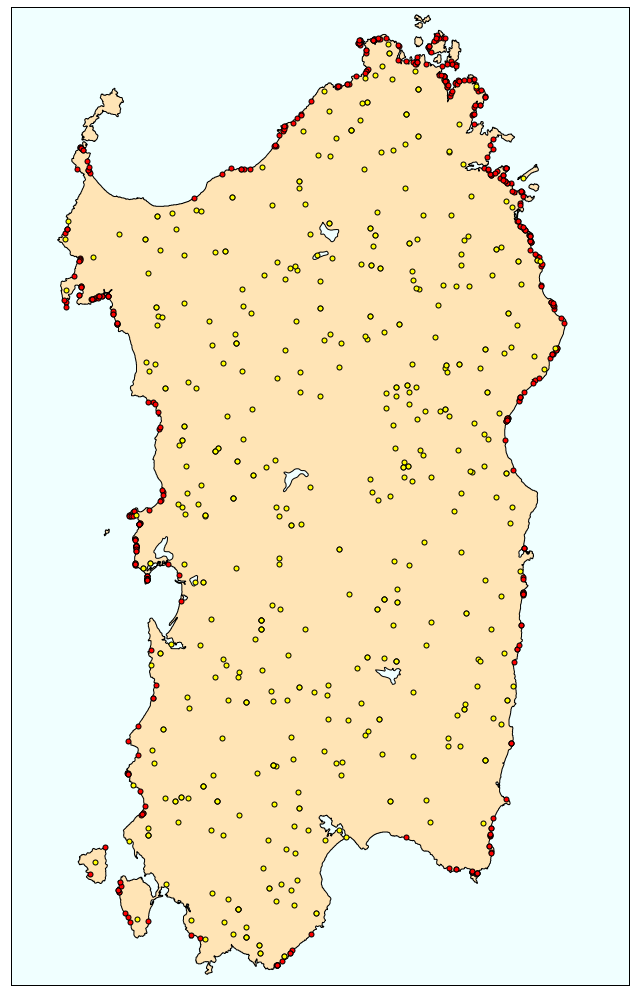

In [13]:
fig=plt.figure(figsize=(18, 18))
m = Basemap(width=175000,height=277000,projection='aeqd',
            resolution='f',lat_0=40.083,lon_0=9.01, ellps="WGS84")


m.drawmapboundary(fill_color='azure')
m.fillcontinents(color='moccasin',lake_color='azure')
m.drawcoastlines()

lat1=presence_df["decimalLatitude"]
lon1=presence_df["decimalLongitude"]


points_x1=[]
points_y1=[]


lat2=absence_df["decimalLatitude"]
lon2=absence_df["decimalLongitude"]


points_x2=[]
points_y2=[]
    
# Plot presence on the map
for i in range(0,len(lon1)):
    xpt,ypt = m(lon1[i],lat1[i])
    points_x1.append(xpt)
    points_y1.append(ypt)
m.plot(points_x1,points_y1,"ko",markersize=5,color="red",markeredgecolor="black")

# Plot pseudo-absence on the map
for i in range(0,len(lon2)):
    xpt,ypt = m(lon2[i],lat2[i])
    points_x2.append(xpt)
    points_y2.append(ypt)
m.plot(points_x2,points_y2,"ko",markersize=5,color="yellow",markeredgecolor="black")


plt.show()

In [14]:
# Save occurrences + non-occurrences
gdf = presence.append(absence, ignore_index=True)
gdf.crs= "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
gdf.to_file('Crithmum_Occurrences.gpkg', driver='GPKG', name='Occurrences')
gdf.tail()

,species,CLASS,CODICE,decimalLatitude,decimalLongitude,geometry
933,NaN,0,NaN,40.728632,9.309818,POINT (9.30982 40.72863)
934,NaN,0,NaN,41.165970,9.332172,POINT (9.33217 41.16597)
935,NaN,0,NaN,40.077284,8.720378,POINT (8.72038 40.07728)
936,NaN,0,NaN,40.886568,8.940633,POINT (8.94063 40.88657)
937,NaN,0,NaN,39.020299,8.999040,POINT (8.99904 39.02030)


In [15]:
# List of coordinates
coord_list = [(x,y) for x,y in zip(gdf['geometry'].x , gdf['geometry'].y)]
print(coord_list[0:5])

[(8.476496, 40.253916), (9.626632, 40.224045), (8.188163, 40.642377), (8.160995, 40.575891), (8.156221, 40.579098)]


In [16]:
print('Total number of coordinates: %s' % '{0:,}'.format(len(coord_list)))

Total number of coordinates: 938


In [17]:
import glob
# grab climate features - cropped to joshua tree study area
raster_features = sorted(glob.glob(
    '/kaggle/input/bioclimatic-variables-cliped/Bio_*.tif'))
# check number of features 
print('\nThere are', len(raster_features), 'raster features.')


There are 19 raster features.


In [18]:
raster_features

['/kaggle/input/bioclimatic-variables-cliped/Bio_10_clip.tif',
 '/kaggle/input/bioclimatic-variables-cliped/Bio_11_clip.tif',
 '/kaggle/input/bioclimatic-variables-cliped/Bio_12_clip.tif',
 '/kaggle/input/bioclimatic-variables-cliped/Bio_13_clip.tif',
 '/kaggle/input/bioclimatic-variables-cliped/Bio_14_clip.tif',
 '/kaggle/input/bioclimatic-variables-cliped/Bio_15_clip.tif',
 '/kaggle/input/bioclimatic-variables-cliped/Bio_16_clip.tif',
 '/kaggle/input/bioclimatic-variables-cliped/Bio_17_clip.tif',
 '/kaggle/input/bioclimatic-variables-cliped/Bio_18_clip.tif',
 '/kaggle/input/bioclimatic-variables-cliped/Bio_19_clip.tif',
 '/kaggle/input/bioclimatic-variables-cliped/Bio_1_clip.tif',
 '/kaggle/input/bioclimatic-variables-cliped/Bio_2_clip.tif',
 '/kaggle/input/bioclimatic-variables-cliped/Bio_3_clip.tif',
 '/kaggle/input/bioclimatic-variables-cliped/Bio_4_clip.tif',
 '/kaggle/input/bioclimatic-variables-cliped/Bio_5_clip.tif',
 '/kaggle/input/bioclimatic-variables-cliped/Bio_6_clip.tif'

In [19]:
# Point sampling
for f in raster_features:
    src = rasterio.open(f)
    gdf[Path(f).stem] = [x for x in src.sample(coord_list)]
    gdf[Path(f).stem] = gdf[Path(f).stem].astype('float64')
train_vec = gdf[gdf.columns.difference(['decimalLatitude', 'decimalLongitude', 'geometry', 'CODICE', 'species'])] # drop columns
train_vec.head()

,Bio_10_clip,Bio_11_clip,Bio_12_clip,Bio_13_clip,Bio_14_clip,Bio_15_clip,Bio_16_clip,Bio_17_clip,Bio_18_clip,Bio_19_clip,Bio_1_clip,Bio_2_clip,Bio_3_clip,Bio_4_clip,Bio_5_clip,Bio_6_clip,Bio_7_clip,Bio_8_clip,Bio_9_clip,CLASS
0,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,1
1,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,1
2,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,1
3,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,1
4,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,1


In [20]:
# Names of bioclimatic variables
columns = list(train_vec.columns[0:19])
print(columns)

['Bio_10_clip', 'Bio_11_clip', 'Bio_12_clip', 'Bio_13_clip', 'Bio_14_clip', 'Bio_15_clip', 'Bio_16_clip', 'Bio_17_clip', 'Bio_18_clip', 'Bio_19_clip', 'Bio_1_clip', 'Bio_2_clip', 'Bio_3_clip', 'Bio_4_clip', 'Bio_5_clip', 'Bio_6_clip', 'Bio_7_clip', 'Bio_8_clip', 'Bio_9_clip']


In [21]:
# NODATA error detection in case of point sampling: bioclimatic variables have the same value
nodata_df = train_vec[train_vec[columns].nunique(axis=1) == 1]
nodata_df.head()

,Bio_10_clip,Bio_11_clip,Bio_12_clip,Bio_13_clip,Bio_14_clip,Bio_15_clip,Bio_16_clip,Bio_17_clip,Bio_18_clip,Bio_19_clip,Bio_1_clip,Bio_2_clip,Bio_3_clip,Bio_4_clip,Bio_5_clip,Bio_6_clip,Bio_7_clip,Bio_8_clip,Bio_9_clip,CLASS
0,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,1
1,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,1
2,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,1
3,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,1
4,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,1


In [22]:
# Saving training data
train_vec.drop(nodata_df.index).to_csv('TRAIN_VEC.csv',index=False)
train_vec = pd.read_csv("TRAIN_VEC.csv")
train_vec.head()

,Bio_10_clip,Bio_11_clip,Bio_12_clip,Bio_13_clip,Bio_14_clip,Bio_15_clip,Bio_16_clip,Bio_17_clip,Bio_18_clip,Bio_19_clip,Bio_1_clip,Bio_2_clip,Bio_3_clip,Bio_4_clip,Bio_5_clip,Bio_6_clip,Bio_7_clip,Bio_8_clip,Bio_9_clip,CLASS
0,24.682142,11.358334,301.0,43.0,4.0,52.068214,126.0,23.0,49.0,95.0,17.353273,8.010119,34.346607,558.063721,30.728571,7.407143,23.321428,15.201191,24.417858,1
1,24.682142,11.358334,301.0,43.0,4.0,52.068214,126.0,23.0,49.0,95.0,17.353273,8.010119,34.346607,558.063721,30.728571,7.407143,23.321428,15.201191,24.417858,1
2,24.078125,10.820833,291.0,47.0,5.0,55.242653,118.0,19.0,61.0,94.0,16.825001,8.808333,36.854950,555.743530,30.424999,6.525000,23.900000,18.344791,23.810417,1
3,24.078125,10.820833,291.0,47.0,5.0,55.242653,118.0,19.0,61.0,94.0,16.825001,8.808333,36.854950,555.743530,30.424999,6.525000,23.900000,18.344791,23.810417,1
4,23.136000,10.424000,487.0,74.0,7.0,52.910366,208.0,38.0,55.0,168.0,16.231001,6.456000,31.020565,531.077698,27.912001,7.100000,20.812000,14.364000,22.854000,1


# Section 2. Species Suitability Mapping

In [23]:
# training data: explanatory variables + response variables
train_xs, train_y = train_vec.iloc[:,0:19].values, train_vec.iloc[:,19].values
# target data: explanatory variables
target_xs, raster_info = pyimpute.load_targets(raster_features)
# Check the shape of the training data
train_xs.shape, train_y.shape

((669, 19), (669,))

In [24]:
train_y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [25]:
# ML 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import BaggingClassifier 
from sklearn.ensemble import GradientBoostingClassifier 
from xgboost import XGBClassifier 
from lightgbm import LGBMClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn import model_selection 
from sklearn import metrics 

In [26]:
# ML classifier dictionary: name: (model)
CLASS_MAP = {
    'RF': (RandomForestClassifier()), 
    'ET': (ExtraTreesClassifier()), 
    'ADA' : (AdaBoostClassifier()), 
    'BAG' : (BaggingClassifier()), 
    'GRA' : (GradientBoostingClassifier()), 
    'XGB': (XGBClassifier()), 
    'LGBM': (LGBMClassifier()), 
    'Maxent':(LogisticRegression()), 
    }

In [27]:
# ROC 
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

In [28]:
# Classifier evaluation functions (modify pyimpute function)
def evaluate_clf(
    clf, X, y, name, k=None, test_size=0.2, scoring="f1_weighted", feature_names=None
):
    X_train, X_test, y_train, y_true = model_selection.train_test_split(
        X, y,
        test_size=test_size, # Test data size
        shuffle=True, # Shuffle the data before split
        stratify=y # Keeping the appearance/non-appearance ratio of Y
    )

    if k: # Cross-validation
        kf = model_selection.KFold(n_splits=k) # k-fold
        scores = model_selection.cross_val_score(clf, X_train, y_train, cv=kf, scoring=scoring)
        print(name + " %d-fold Cross Validation Accuracy: %0.2f (+/- %0.2f)"
              % (k, scores.mean() * 100, scores.std() * 200))
        print()
    
    clf.fit(X_train, y_train) # Training of classifiers
    y_pred = clf.predict(X_test) # Classifier predictions
    
    # Classifier evaluation metrics
    print("Accuracy Score: %.2f" % metrics.accuracy_score(y_true, y_pred))
    print()

    print("Classification report")
    print(metrics.classification_report(y_true, y_pred))
    print()

    print("Confussion matrix")
    print(metrics.confusion_matrix(y_true, y_pred))
    print()
    
    print('AUC(ROC): %.2f'% metrics.roc_auc_score(y_true, y_pred))
    print()
       
    # ROC 
    probs = clf.predict_proba(X_test) 
    prob = probs[:, 1]  
    fper, tper, thresholds = metrics.roc_curve(y_true, prob)
    plot_roc_curve(fper, tper)

    if hasattr(clf, "feature_importances_"):
        print("Feature importances")
        for f, imp in zip(feature_names, clf.feature_importances_):
            print("%20s: %s" % (f, round(imp * 100, 1)))
        print()

RF 5-fold Cross Validation Accuracy: 94.40 (+/- 2.03)

Accuracy Score: 0.93

Classification report
              precision    recall  f1-score   support

           0       0.99      0.91      0.95        92
           1       0.84      0.98      0.90        42

    accuracy                           0.93       134
   macro avg       0.91      0.94      0.93       134
weighted avg       0.94      0.93      0.93       134


Confussion matrix
[[84  8]
 [ 1 41]]

AUC(ROC): 0.94



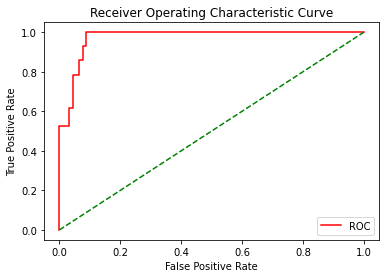

Feature importances
         Bio_10_clip: 2.4
         Bio_11_clip: 16.0
         Bio_12_clip: 3.8
         Bio_13_clip: 1.6
         Bio_14_clip: 1.2
         Bio_15_clip: 3.1
         Bio_16_clip: 3.1
         Bio_17_clip: 2.7
         Bio_18_clip: 3.4
         Bio_19_clip: 2.6
          Bio_1_clip: 6.9
          Bio_2_clip: 2.7
          Bio_3_clip: 3.4
          Bio_4_clip: 17.9
          Bio_5_clip: 3.1
          Bio_6_clip: 9.9
          Bio_7_clip: 5.7
          Bio_8_clip: 8.4
          Bio_9_clip: 1.9

ET 5-fold Cross Validation Accuracy: 92.17 (+/- 3.17)

Accuracy Score: 0.93

Classification report
              precision    recall  f1-score   support

           0       0.98      0.91      0.94        92
           1       0.83      0.95      0.89        42

    accuracy                           0.93       134
   macro avg       0.91      0.93      0.92       134
weighted avg       0.93      0.93      0.93       134


Confussion matrix
[[84  8]
 [ 2 40]]

AUC(ROC): 0.93



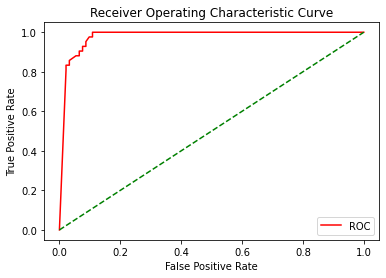

Feature importances
         Bio_10_clip: 3.7
         Bio_11_clip: 10.2
         Bio_12_clip: 4.5
         Bio_13_clip: 3.6
         Bio_14_clip: 2.5
         Bio_15_clip: 2.8
         Bio_16_clip: 3.2
         Bio_17_clip: 4.4
         Bio_18_clip: 3.9
         Bio_19_clip: 3.7
          Bio_1_clip: 5.9
          Bio_2_clip: 4.2
          Bio_3_clip: 3.8
          Bio_4_clip: 13.3
          Bio_5_clip: 3.2
          Bio_6_clip: 11.1
          Bio_7_clip: 7.2
          Bio_8_clip: 5.7
          Bio_9_clip: 3.1

ADA 5-fold Cross Validation Accuracy: 91.49 (+/- 3.22)

Accuracy Score: 0.96

Classification report
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        92
           1       0.97      0.90      0.94        42

    accuracy                           0.96       134
   macro avg       0.97      0.95      0.96       134
weighted avg       0.96      0.96      0.96       134


Confussion matrix
[[91  1]
 [ 4 38]]

AUC(ROC): 0.95



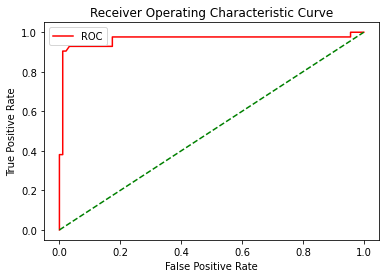

Feature importances
         Bio_10_clip: 0.0
         Bio_11_clip: 12.0
         Bio_12_clip: 2.0
         Bio_13_clip: 2.0
         Bio_14_clip: 4.0
         Bio_15_clip: 8.0
         Bio_16_clip: 10.0
         Bio_17_clip: 4.0
         Bio_18_clip: 4.0
         Bio_19_clip: 2.0
          Bio_1_clip: 4.0
          Bio_2_clip: 2.0
          Bio_3_clip: 4.0
          Bio_4_clip: 10.0
          Bio_5_clip: 4.0
          Bio_6_clip: 8.0
          Bio_7_clip: 10.0
          Bio_8_clip: 4.0
          Bio_9_clip: 6.0

BAG 5-fold Cross Validation Accuracy: 93.09 (+/- 5.08)

Accuracy Score: 0.93

Classification report
              precision    recall  f1-score   support

           0       0.96      0.93      0.95        92
           1       0.86      0.90      0.88        42

    accuracy                           0.93       134
   macro avg       0.91      0.92      0.91       134
weighted avg       0.93      0.93      0.93       134


Confussion matrix
[[86  6]
 [ 4 38]]

AUC(ROC): 0.92


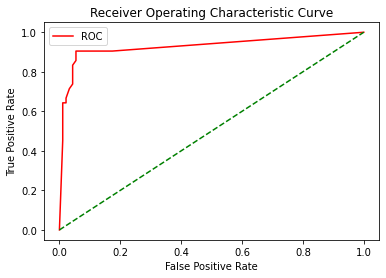

GRA 5-fold Cross Validation Accuracy: 92.28 (+/- 5.35)

Accuracy Score: 0.93

Classification report
              precision    recall  f1-score   support

           0       0.98      0.92      0.95        92
           1       0.85      0.95      0.90        42

    accuracy                           0.93       134
   macro avg       0.91      0.94      0.92       134
weighted avg       0.94      0.93      0.93       134


Confussion matrix
[[85  7]
 [ 2 40]]

AUC(ROC): 0.94



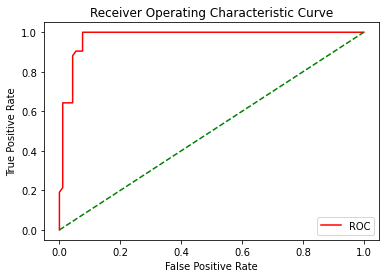

Feature importances
         Bio_10_clip: 0.3
         Bio_11_clip: 41.2
         Bio_12_clip: 0.6
         Bio_13_clip: 0.7
         Bio_14_clip: 0.0
         Bio_15_clip: 1.9
         Bio_16_clip: 0.9
         Bio_17_clip: 4.9
         Bio_18_clip: 4.0
         Bio_19_clip: 0.9
          Bio_1_clip: 0.1
          Bio_2_clip: 0.3
          Bio_3_clip: 1.3
          Bio_4_clip: 20.9
          Bio_5_clip: 1.3
          Bio_6_clip: 18.2
          Bio_7_clip: 0.6
          Bio_8_clip: 1.6
          Bio_9_clip: 0.4

XGB 5-fold Cross Validation Accuracy: 93.86 (+/- 6.28)

Accuracy Score: 0.93

Classification report
              precision    recall  f1-score   support

           0       0.95      0.96      0.95        92
           1       0.90      0.88      0.89        42

    accuracy                           0.93       134
   macro avg       0.92      0.92      0.92       134
weighted avg       0.93      0.93      0.93       134


Confussion matrix
[[88  4]
 [ 5 37]]

AUC(ROC): 0.92



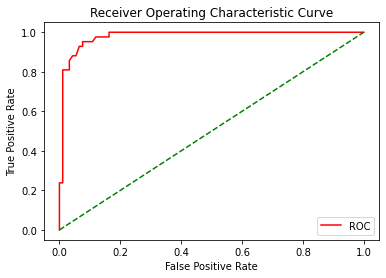

Feature importances
         Bio_10_clip: 2.4
         Bio_11_clip: 40.9
         Bio_12_clip: 2.1
         Bio_13_clip: 0.9
         Bio_14_clip: 1.3
         Bio_15_clip: 2.7
         Bio_16_clip: 1.8
         Bio_17_clip: 6.5
         Bio_18_clip: 8.7
         Bio_19_clip: 1.2
          Bio_1_clip: 2.4
          Bio_2_clip: 4.7
          Bio_3_clip: 1.2
          Bio_4_clip: 12.9
          Bio_5_clip: 1.2
          Bio_6_clip: 3.7
          Bio_7_clip: 2.9
          Bio_8_clip: 1.3
          Bio_9_clip: 1.2

LGBM 5-fold Cross Validation Accuracy: 91.83 (+/- 6.41)

Accuracy Score: 0.94

Classification report
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        92
           1       0.90      0.90      0.90        42

    accuracy                           0.94       134
   macro avg       0.93      0.93      0.93       134
weighted avg       0.94      0.94      0.94       134


Confussion matrix
[[88  4]
 [ 4 38]]

AUC(ROC): 0.93



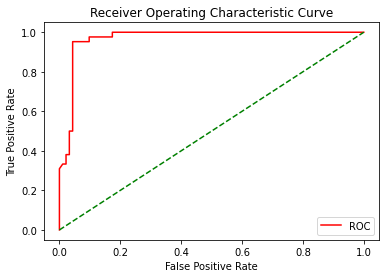

Feature importances
         Bio_10_clip: 8500
         Bio_11_clip: 27200
         Bio_12_clip: 10500
         Bio_13_clip: 5700
         Bio_14_clip: 3800
         Bio_15_clip: 14700
         Bio_16_clip: 6600
         Bio_17_clip: 12800
         Bio_18_clip: 5700
         Bio_19_clip: 10700
          Bio_1_clip: 6800
          Bio_2_clip: 8400
          Bio_3_clip: 13000
          Bio_4_clip: 25500
          Bio_5_clip: 9900
          Bio_6_clip: 21900
          Bio_7_clip: 13300
          Bio_8_clip: 10900
          Bio_9_clip: 5100

Maxent 5-fold Cross Validation Accuracy: 91.29 (+/- 2.99)

Accuracy Score: 0.92

Classification report
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        92
           1       0.86      0.88      0.87        42

    accuracy                           0.92       134
   macro avg       0.90      0.91      0.91       134
weighted avg       0.92      0.92      0.92       134


Confussion matrix
[[86  6

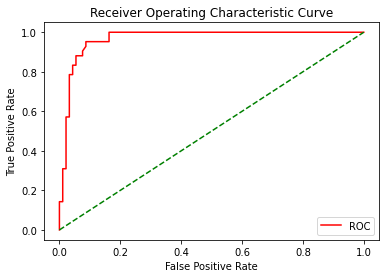

In [29]:
# Spatial prediction
for name, model in CLASS_MAP.items():
    evaluate_clf(model, train_xs, train_y, name, k=5, test_size=0.2, scoring="f1_weighted", feature_names=columns)
    try:
        os.mkdir('OUTPUT/' + name + '-IMAGES')        
    except:
        pass    
    pyimpute.impute(target_xs, model, raster_info, outdir='OUTPUT/' + name + '-IMAGES', class_prob=True, certainty=True)

In [30]:
distr_rf = rasterio.open("/kaggle/working/OUTPUT/RF-IMAGES/probability_1.tif").read(1) 
distr_et = rasterio.open("/kaggle/working/OUTPUT/ET-IMAGES/probability_1.tif").read(1)  
distr_ada =  rasterio.open("/kaggle/working/OUTPUT/ADA-IMAGES/probability_1.tif").read(1)  
distr_bag =  rasterio.open("/kaggle/working/OUTPUT/BAG-IMAGES/probability_1.tif").read(1) 
distr_gra =  rasterio.open("/kaggle/working/OUTPUT/GRA-IMAGES/probability_1.tif").read(1)  
distr_xgb =  rasterio.open("/kaggle/working/OUTPUT/XGB-IMAGES/probability_1.tif").read(1)  
distr_lgbm =  rasterio.open("/kaggle/working/OUTPUT/LGBM-IMAGES/probability_1.tif").read(1)  
distr_max =  rasterio.open("/kaggle/working/OUTPUT/Maxent-IMAGES/probability_1.tif").read(1)  

distr_averaged = (distr_rf + distr_et + distr_ada + distr_bag + distr_gra + 
                  distr_xgb + distr_lgbm + distr_max) / 8

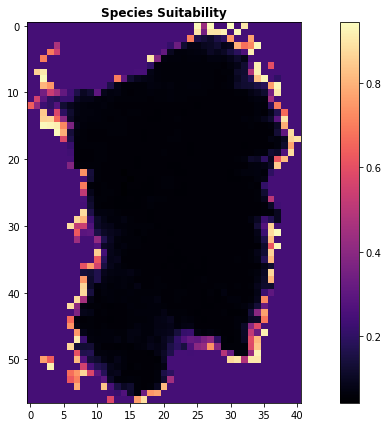

In [31]:
def plotit(x, title, cmap="Blues"):
    plt.figure(figsize = (14,7))
    plt.imshow(x, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.title(title, fontweight = 'bold')
plotit(distr_averaged, "Species Suitability", cmap="magma")

As you can see from the map, the probability of distribution had a very high accuracy (about 93/94%)